# Cruce DMM a Beam

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:


# ===== DMM ==================================
columns = ["ts", "IDC", "IAC"]
#file_path = r'..\0_raw\dmm_data6894024_2022_05_27_212453_all.dat' # este no calza con ningun beam data por los tiempos
file_path = r'..\0_raw\dmm_data_2022_06_02-14_all.dat'

# Posibles errores al leer este tipo de archivos
#Abro el fichero, reemplazo los '\x00' y guardo en memoria
with open(file_path, 'r', encoding='latin-1', errors='ignore') as f:
    text = f.read().replace('\x00', '')

from io import StringIO
df = pd.read_csv( StringIO(text), delim_whitespace=True,
    names=columns, comment="#", engine="python"
)

# !!!! === Para todos los archivos DMM necesitamos agregar 2 horas? === !!!!!
df["Time"] = pd.to_datetime(df["ts"], unit="s") + pd.Timedelta(hours=2) # time stamps

df = df.set_index("Time")

print(df.isna().sum())                     # Buscar NaN

# Aseguramos que 'df' tenga columna Time:
if df.index.name == "Time" or df.index.dtype.kind == "M":
    df_curr = df.reset_index()
else:
    df_curr = df.copy()
    if "Time" not in df_curr.columns:
        raise KeyError("df debe tener columna o índice llamado 'Time' en formato datetime.")
    df_curr["Time"] = pd.to_datetime(df_curr["Time"])

# ===== Beam ===================================
beam_data = pd.read_csv("./csv/beam_data.csv")

print(beam_data.isna().sum())              # Buscar NaN



ts     0
IDC    0
IAC    0
dtype: int64
Time         0
TID          0
HEH          0
N1MeV        0
run_group    0
dtype: int64


,Time,TID,HEH,N1MeV,run_group
0,2022-05-25 10:09:53.517351680,488.022822,1.060544e+12,5.839896e+12,7
1,2022-05-25 10:10:44.276027648,488.027711,1.060544e+12,5.841454e+12,7
2,2022-05-25 10:11:35.034703616,488.025729,1.060544e+12,5.842470e+12,7
3,2022-05-25 10:12:25.793379328,488.033527,1.060544e+12,5.843457e+12,7
4,2022-05-25 10:13:16.552055040,488.017482,1.060544e+12,5.844933e+12,7


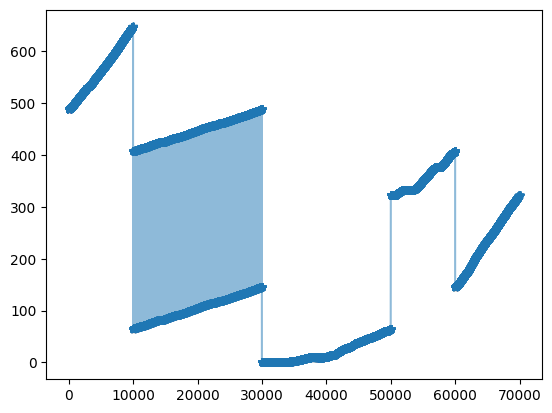

In [4]:
plt.plot(beam_data["TID"], '*-', alpha=0.5)
beam_data.head()

In [5]:
df_curr.iloc[0]

Time    2022-06-01 12:01:01.485782784
ts                  1654077661.485783
IDC                            0.6231
IAC                          0.000012
Name: 0, dtype: object

## cruce con datos beam

In [6]:
# --- funcion para cruce de fechas ---

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Asegurarse de que ambas columnas “Time” estén en datetime64
beam_data["Time"]   = pd.to_datetime(beam_data["Time"])
df_curr["Time"]     = pd.to_datetime(df_curr["Time"])

time1 = beam_data["Time"] 
time2 = df_curr["Time"]

def coincidence_time(time1: pd.core.frame.DataFrame, time2: pd.core.frame.DataFrame, data_labels=["Beam", "DMM"], time_index = "Time"):

    time1_sorted = time1.sort_values(time_index)
    time2_sorted = time2.sort_values(time_index)

    # Calcular rango de solape
    t_min = max(time2_sorted[time_index].min(), time1_sorted[time_index].min())
    t_max = min(time2_sorted[time_index].max(), time1_sorted[time_index].max())

    # === plot ===
    fig, ax = plt.subplots(figsize=(10, 3))

    # Se pinta la región de solape
    ax.axvspan(t_min, t_max, color="lightgrey", alpha=0.5, label="Zona de solape")

    # Graficar beam_data como un eventplot (número 1)
    ax.eventplot(time1_sorted[time_index], lineoffsets=1, linelengths=0.4, colors="tab:blue", label=f"{data_labels[0]} data")
    ax.eventplot(time2_sorted[time_index], lineoffsets=0, linelengths=0.4, colors="tab:orange", label=f"{data_labels[1]} data")

    ax.set_yticks([0, 1])
    ax.set_yticklabels([data_labels[1], data_labels[0]])
    ax.set_xlabel(time_index)
    ax.set_title(f"Timestamps de {data_labels[1]} vs {data_labels[0]} y zona de solape")
    ax.legend(loc="upper right")


    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    fig.autofmt_xdate(rotation=30)

    plt.show()

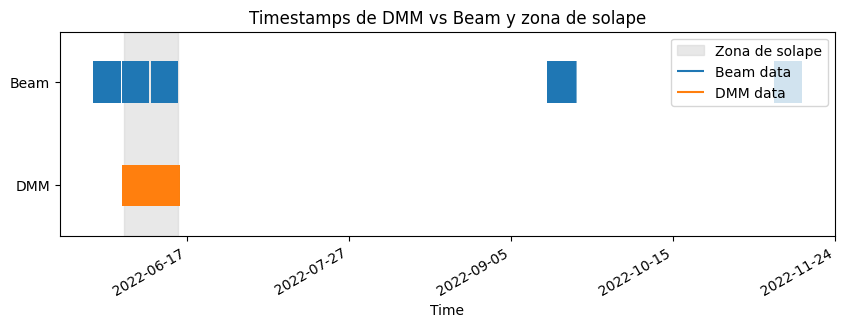

In [7]:
beam_data["Time"]   = pd.to_datetime(beam_data["Time"])
df_curr["Time"]     = pd.to_datetime(df_curr["Time"])

coincidence_time(beam_data, df_curr, data_labels=["Beam", "DMM"])

Se observa una coincidencia de fechas para este archivo

In [8]:
# Convertir beam_data["Time"] de string a datetime64[ns]
print(type(beam_data.loc[0, "Time"]))  # sale <class 'str'>
beam_data["Time"] = pd.to_datetime(beam_data["Time"])
print(type(beam_data.loc[0, "Time"]))  # debería salir <class 'pandas._libs.tslibs.timestamps.Timestamp'>

# Asegurarnos de que df_curr["Time"] también esté en datetime64[ns]
if not pd.api.types.is_datetime64_any_dtype(df_curr["Time"]):
    df_curr["Time"] = pd.to_datetime(df_curr["Time"])

# Cómo funciona pd.merge_asof(...):
#    - Ambos dataframes DEBEN estar ordenados ascendentemente por la columna "Time".
#    - Para cada fila en df_curr, busca la fila en beam_data_sorted cuya "Time" sea
#      la más cercana (en distancia absoluta) dentro de ±1 segundo (tolerance).
#    - Si ENCUENTRA un registro de beam_data a menos de 1 s, lo junta; si no, deja NaN.
#
df_curr = df_curr.sort_values("Time").reset_index(drop=True)
beam_data_sorted = beam_data.sort_values("Time").reset_index(drop=True)

merged = pd.merge_asof(
    df_curr,
    beam_data_sorted,
    on="Time",
    direction="nearest",
    tolerance=pd.Timedelta(seconds=1)
)

# Después del merge, cualquier fila de df_curr que no tenga correspondencia en beam_data
#    dentro de 1 segundo aparecerá con NaN en las columnas nuevas (TID, HEH, etc.).
#    Podemos detectar esos casos así:
missing_mask = merged[["TID", "HEH", "N1MeV", "run_group"]].isna().any(axis=1)
print("Filas sin match en ±1 s:", missing_mask.sum())


merged.dropna()
# antes de conversión es objeto (string)
print(type(beam_data.loc[0, "Time"]))  # sale <class 'str'>
beam_data["Time"] = pd.to_datetime(beam_data["Time"])
print(type(beam_data.loc[0, "Time"]))  # debería salir <class 'pandas._libs.tslibs.timestamps.Timestamp'>

# Asegurarnos de que df_curr["Time"] también esté en datetime64[ns]
if not pd.api.types.is_datetime64_any_dtype(df_curr["Time"]):
    df_curr["Time"] = pd.to_datetime(df_curr["Time"])

# ---
# por el cambio de 2 hrs podria necesitar esto,
# pero no encontré referencias documentadas de que datos usan o no la conversión
seconds_tolerance = 1
# ---

# Cómo funciona pd.merge_asof(...):
#    - Ambos dataframes DEBEN estar ordenados ascendentemente por la columna "Time".
#    - Para cada fila en df_curr, busca la fila en beam_data_sorted cuya "Time" sea
#      la más cercana (en distancia absoluta) dentro de ±1 segundo (tolerance).
#    - Si ENCUENTRA un registro de beam_data a menos de 1 s, lo junta; si no, deja NaN.
df_curr = df_curr.sort_values("Time").reset_index(drop=True)
beam_data_sorted = beam_data.sort_values("Time").reset_index(drop=True)
merged = pd.merge_asof(
    df_curr,
    beam_data_sorted,
    on="Time",
    direction="nearest",
    tolerance=pd.Timedelta(seconds=seconds_tolerance)
)

# Después del merge, cualquier fila de df_curr que no tenga correspondencia en beam_data
missing_mask = merged[["TID", "HEH", "N1MeV", "run_group"]].isna().any(axis=1) 
print("Filas sin match en ±1 s:", missing_mask.sum())

# quitamos esas filas
merged.dropna(inplace=True)
print(merged.shape)
merged.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Filas sin match en ±1 s: 259604
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Filas sin match en ±1 s: 259604
(14254, 8)


,Time,ts,IDC,IAC,TID,HEH,N1MeV,run_group
2637,2022-06-01 15:02:32.488089088,1.654089e+09,0.6228,0.000012,407.106078,8.718021e+11,4.743248e+12,6.0
2649,2022-06-01 15:03:22.035902976,1.654089e+09,0.6228,0.000012,407.087570,8.718216e+11,4.742606e+12,6.0
2661,2022-06-01 15:04:11.608589312,1.654089e+09,0.6227,0.000012,64.853168,1.515463e+11,8.999960e+11,3.0
2673,2022-06-01 15:05:01.127783168,1.654089e+09,0.6227,0.000012,407.159775,8.718826e+11,4.743641e+12,6.0
2685,2022-06-01 15:05:50.695138304,1.654089e+09,0.6226,0.000012,64.873975,1.516115e+11,8.995171e+11,3.0


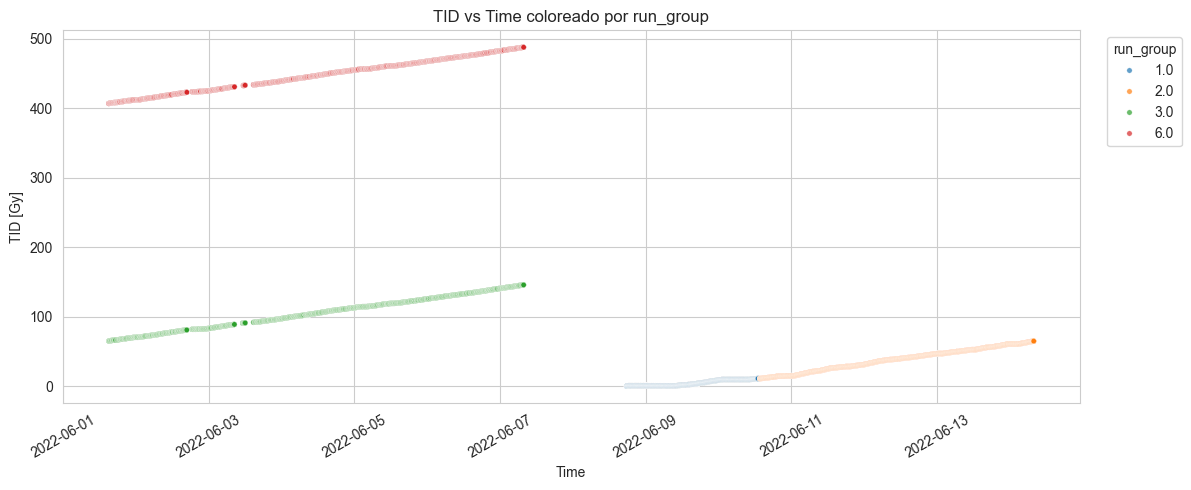

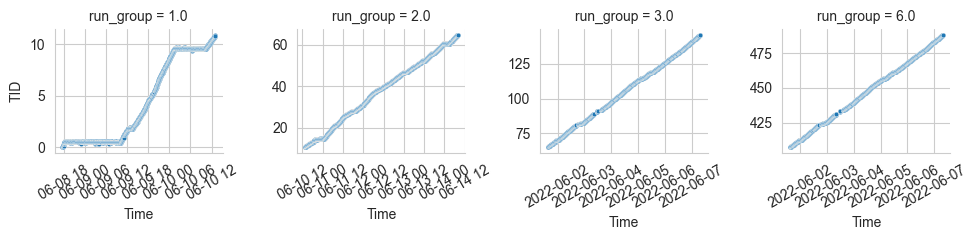

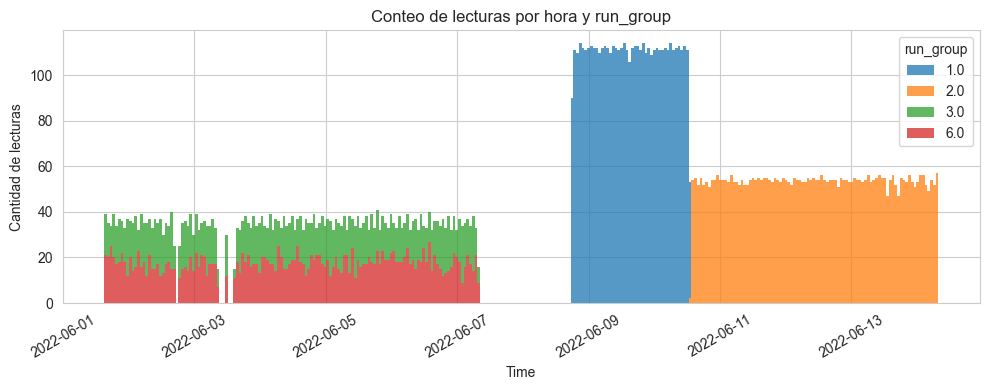

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


df_vis = merged.reset_index()

# Configurar estilo
sns.set_style("whitegrid")

# 1) Scatter de TID vs Time, coloreado por run_group
plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=df_vis,
    x="Time", 
    y="TID", 
    hue="run_group", 
    palette="tab10", 
    s=15,
    alpha=0.7
)
plt.title("TID vs Time coloreado por run_group")
plt.xlabel("Time")
plt.ylabel("TID [Gy]")
plt.legend(title="run_group", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# 2) FacetGrid: cada run en un subplot separado (para detectar solapamientos de timestamps)
g = sns.FacetGrid(df_vis, col="run_group", col_wrap=4, height=2.5, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="Time", y="TID", s=10, color="tab:blue")
g.set_axis_labels("Time", "TID")
g.set_titles(col_template="run_group = {col_name}")
for ax in g.axes.flatten():
    ax.tick_params(axis="x", rotation=30)
plt.tight_layout()
plt.show()

# 3) Histograma de conteo de timestamps por run_group en intervalos de 1 hora
plt.figure(figsize=(10, 4))
sns.histplot(
    data=df_vis, 
    x="Time", 
    hue="run_group", 
    multiple="stack", 
    bins=int((df_vis["Time"].max() - df_vis["Time"].min()).total_seconds() / 3600),
    palette="tab10",
    edgecolor="none"
)
plt.title("Conteo de lecturas por hora y run_group")
plt.xlabel("Time")
plt.ylabel("Cantidad de lecturas")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [10]:
# Q&A que grupo tomar?
# existe un mapeo o una lista para que concuerda con cada .dat?



In [11]:
merged_analysis = merged[(merged["run_group"] == 1)].copy()
merged_analysis = merged_analysis.drop(["ts"], axis=1)
merged_analysis = merged_analysis.set_index("Time")
merged_analysis.head()

,IDC,IAC,TID,HEH,N1MeV,run_group
Time,,,,,,
2022-06-08 17:41:03.857579008,0.6220,0.000012,-0.009340,1.186084e+07,4.373562e+08,1.0
2022-06-08 17:41:20.364343040,0.6220,0.000012,0.027499,1.201001e+07,1.342623e+08,1.0
2022-06-08 17:42:05.808532992,0.6220,0.000012,-0.007062,4.031827e+07,-1.683817e+08,1.0
2022-06-08 17:42:22.299005184,0.6220,0.000012,0.021207,4.692837e+07,3.222023e+08,1.0
2022-06-08 17:43:24.242434560,0.6219,0.000012,0.063127,7.782957e+07,-1.912239e+08,1.0


In [12]:
# corr de poco interes
# la radiacion tiene mucha correlacion de pearson
# corr_matrix = merged_analysis.corr()

# # Create a heatmap
# import seaborn as sns
# plt.figure(figsize=(8, 6))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
# plt.title('Cross-Correlation Heatmap')
# plt.show()



## Failure

0.2423
0.4632
0.6224
                               Duración_s  Idle_previo  Off_detectado  \
Time_event                                                              
2022-06-09 12:50:23.809811200          78       0.6186           -0.0   
2022-06-09 18:29:42.319063552          94       0.6146            0.0   
2022-06-09 21:00:37.313351424         796       0.5726            0.0   
2022-06-09 21:49:32.711532288         780       0.6136            0.0   

                                            Recuperación_en  IDC_recuperación  
Time_event                                                                     
2022-06-09 12:50:23.809811200 2022-06-09 12:51:42.209988096            0.7282  
2022-06-09 18:29:42.319063552 2022-06-09 18:31:17.165928960            0.6267  
2022-06-09 21:00:37.313351424 2022-06-09 21:13:54.004310016            0.7228  
2022-06-09 21:49:32.711532288 2022-06-09 22:02:33.039615488            0.7229  


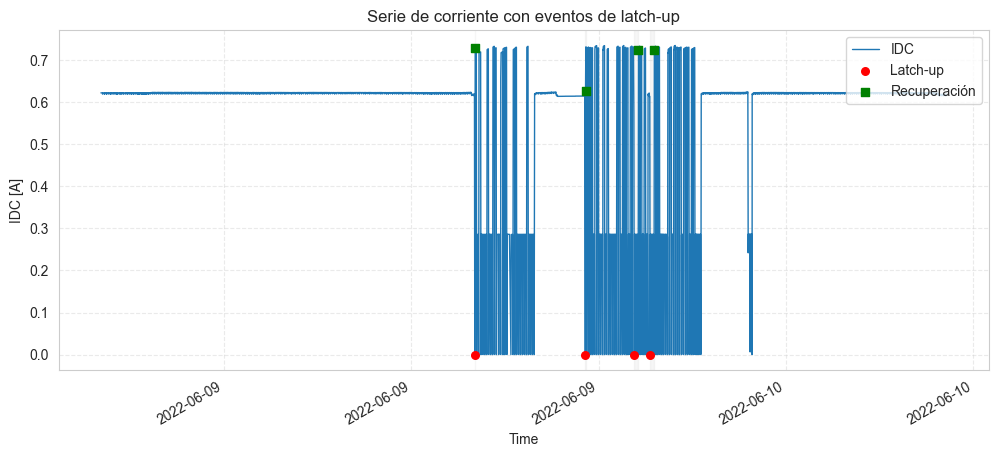

,Duración_s,Idle_previo,Off_detectado,Recuperación_en,IDC_recuperación
Time_event,,,,,
2022-06-09 12:50:23.809811200,78,0.6186,-0.0,2022-06-09 12:51:42.209988096,0.7282
2022-06-09 18:29:42.319063552,94,0.6146,0.0,2022-06-09 18:31:17.165928960,0.6267
2022-06-09 21:00:37.313351424,796,0.5726,0.0,2022-06-09 21:13:54.004310016,0.7228
2022-06-09 21:49:32.711532288,780,0.6136,0.0,2022-06-09 22:02:33.039615488,0.7229


In [13]:
percentile = lambda p: np.percentile(df["IDC"].dropna(), p)

p_off = 10
p_idle_low = 50
p_idle_high = 90

OFF_TH = percentile(p_off)       # < 0.01 A → se considera “off” (protección/latch-up)
IDLE_LOW = percentile(p_idle_low)     # ≥ 0.45 A
IDLE_HIGH = percentile(p_idle_high)   # ≤ 0.62 A
print(
    "\n".join([str(OFF_TH), str(IDLE_LOW), str(IDLE_HIGH)])
    )

from lib import detect_latchups,plot_percentile_hist,plot_latchups_on_current

# usar dates de index
merged_latchups = detect_latchups(merged_analysis, "IDC", OFF_TH, IDLE_LOW, IDLE_HIGH)
print(merged_latchups.head())


plot_latchups_on_current(merged_analysis, merged_latchups)

merged_latchups.head()

# Modelado de Resiliencia de Dosis por Latch-Up

Definimos la variable aleatoria $D$ = “dosis hasta latch-up”. A partir de los datos obtenidos cruzando DMM vs beam, extraemos el vector $\{d_i\}$.

- **Exponencial (tasa constante):**  
  $$f(d) = \lambda e^{-\lambda d}, \quad S(d) = e^{-\lambda d}$$  
  $\displaystyle \hat\lambda = 1 / \bar d$.

- **Weibull (envejecimiento o efecto inicial):**  
  $$f(d) = \frac{k}{\eta}\Bigl(\frac{d}{\eta}\Bigr)^{k-1}e^{-(d/\eta)^k}, \quad S(d) = e^{-(d/\eta)^k}$$  
  $\;k\neq 1$ ajusta “drift” de la tasa de falla.

El pipeline espera un arreglo NumPy con dosis al primer latch-up (Gy). Si el formato es distinto (por ejemplo, strings en lugar de floats, o timestamps mal convertidos), las funciones de ajuste fallarán. En la siguiente celda definimos las funciones y en la última hacemos comprobaciones sobre el formato de `dose_to_failure` antes de ajustar los modelos.


In [14]:
import numpy as np
import scipy.stats as st

merged_analysis.head()
merged_latchups.head()


# Asegurarnos de que merged_analysis esté indexado por datetime
if merged_analysis.index.name != "Time" or merged_analysis.index.dtype.kind != "M":
    merged_analysis = merged_analysis.reset_index().set_index("Time")

In [15]:
merged_analysis

,IDC,IAC,TID,HEH,N1MeV,run_group
Time,,,,,,
2022-06-08 17:41:03.857579008,0.6220,0.000012,-0.009340,1.186084e+07,4.373562e+08,1.0
2022-06-08 17:41:20.364343040,0.6220,0.000012,0.027499,1.201001e+07,1.342623e+08,1.0
2022-06-08 17:42:05.808532992,0.6220,0.000012,-0.007062,4.031827e+07,-1.683817e+08,1.0
2022-06-08 17:42:22.299005184,0.6220,0.000012,0.021207,4.692837e+07,3.222023e+08,1.0
2022-06-08 17:43:24.242434560,0.6219,0.000012,0.063127,7.782957e+07,-1.912239e+08,1.0
...,...,...,...,...,...,...
2022-06-10 12:59:13.970202112,0.6155,0.000012,10.832963,2.528340e+10,1.357966e+11,1.0
2022-06-10 12:59:30.567250944,0.6183,0.000012,10.811456,2.528340e+10,1.357586e+11,1.0
2022-06-10 13:00:15.958508800,0.6155,0.000012,10.798754,2.529534e+10,1.357458e+11,1.0


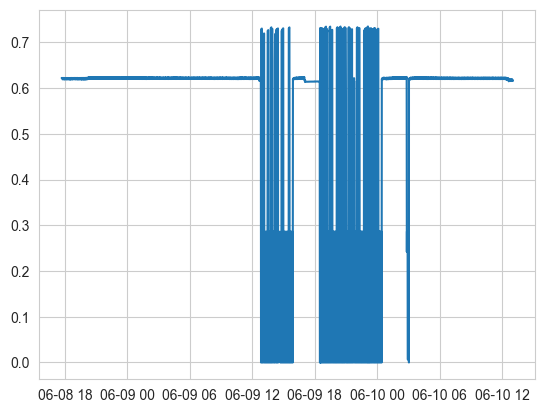

In [16]:
plt.plot(merged_analysis["IDC"])

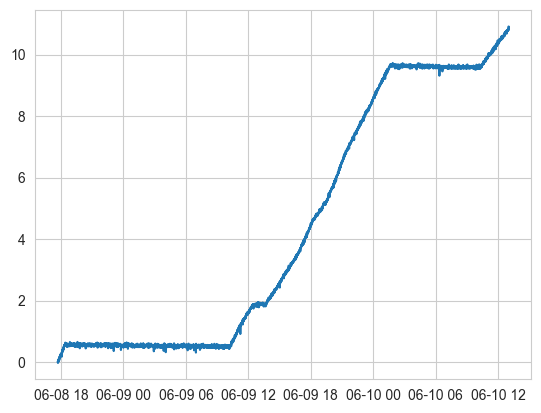

In [17]:
plt.plot(merged_analysis["TID"])

In [18]:
plt.hist?

Signature:
plt.hist(
    x,
    bins=None,
    range=None,
    density=False,
    weights=None,
    cumulative=False,
    bottom=None,
    histtype='bar',
    align='mid',
    orientation='vertical',
    rwidth=None,
    log=False,
    color=None,
    label=None,
    stacked=False,
    *,
    data=None,
    **kwargs,
)
Docstring:
Compute and plot a histogram.

This method uses `numpy.histogram` to bin the data in *x* and count the
number of values in each bin, then draws the distribution either as a
`.BarContainer` or `.Polygon`. The *bins*, *range*, *density*, and
*weights* parameters are forwarded to `numpy.histogram`.

If the data has already been binned and counted, use `~.bar` or
`~.stairs` to plot the distribution::

    counts, bins = np.histogram(x)
    plt.stairs(counts, bins)

Alternatively, plot pre-computed bins and counts using ``hist()`` by
treating each bin as a single point with a weight equal to its count::

    plt.hist(bins[:-1], bins, weights=counts)

The data input

In [19]:
# Extraer vector de dosis D_i
dose_to_failure = merged_analysis.loc[merged_latchups.index, "TID"].to_numpy()

if dose_to_failure.size == 0: # Validaciones básicas
    raise RuntimeError("No se encontraron dosis para los eventos de latch-up.")
if np.any(np.isnan(dose_to_failure)) or np.any(dose_to_failure <= 0):
    raise ValueError("Valores inválidos en dose_to_failure (NaN o ≤ 0). Verificar merged_analysis.")

dose_to_failure

array([1.87685359, 4.74471176, 6.53428565, 7.12726635])

----- Estadísticos descriptivos de dose_to_failure -----
count    4.000000
mean     5.070779
std      2.357857
min      1.876854
1%       1.962889
5%       2.307032
25%      4.027747
50%      5.639499
75%      6.682531
95%      7.038319
99%      7.109477
max      7.127266
Name: Dose_Gy, dtype: float64


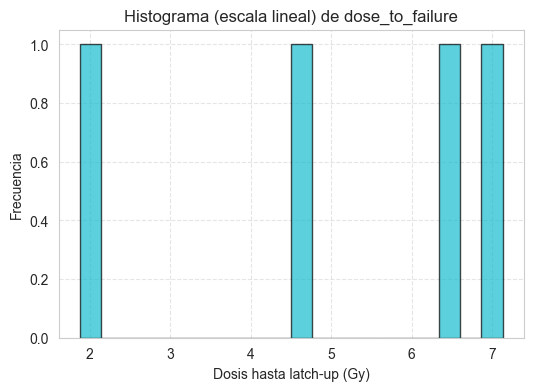

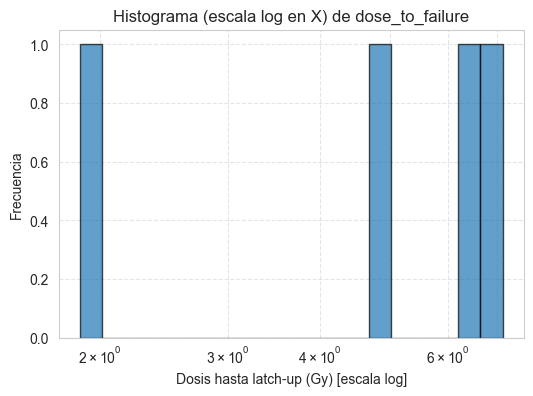

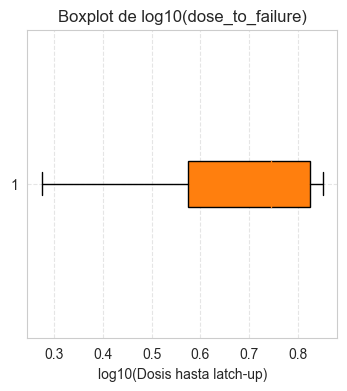

Valores < 1 % ( < 1.962889333952885 Gy):
 [1.87685359]

Valores > 99 % ( > 7.109476927320686 Gy):
 [7.12726635]


In [20]:
d = pd.Series(dose_to_failure, name="Dose_Gy")

# Estadísticos descriptivos
descr = d.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
print("----- Estadísticos descriptivos de dose_to_failure -----")
print(descr)

# Calcular log10(dosis)
log_d = np.log10(d)

# Histograma en escala lineal
plt.figure(figsize=(6, 4))
plt.hist(d, bins=20, color="tab:cyan", edgecolor="k", alpha=0.7)
plt.xlabel("Dosis hasta latch-up (Gy)")
plt.ylabel("Frecuencia")
plt.title("Histograma (escala lineal) de dose_to_failure")
plt.grid(True, ls="--", alpha=0.5)
plt.show()

# Histograma en escala logarítmica (eje X en log10)
plt.figure(figsize=(6, 4))
# Usamos bins equiespaciados en log10
bins_log = np.logspace(np.log10(d.min()), np.log10(d.max()), 20)
plt.hist(d, bins=bins_log, color="tab:blue", edgecolor="k", alpha=0.7)
plt.xscale("log")
plt.xlabel("Dosis hasta latch-up (Gy) [escala log]")
plt.ylabel("Frecuencia")
plt.title("Histograma (escala log en X) de dose_to_failure")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# Boxplot de log10(dosis)
plt.figure(figsize=(4, 4))
plt.boxplot(log_d, vert=False, patch_artist=True,
            boxprops=dict(facecolor="tab:orange", edgecolor="k"))
plt.xlabel("log10(Dosis hasta latch-up)")
plt.title("Boxplot de log10(dose_to_failure)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# Identificar outliers extremos (fuera de percentiles 1% y 99%)
p1  = d.quantile(0.01)
p99 = d.quantile(0.99)
extremes_low  = d[d < p1]
extremes_high = d[d > p99]
print(f"Valores < 1 % ( <", p1, "Gy):\n", extremes_low.values)
print(f"\nValores > 99 % ( >", p99, "Gy):\n", extremes_high.values)

Distribución exponencial

In [21]:
#  Ajustar distribución Exponencial
lambda_hat = 1.0 / dose_to_failure.mean()
n = len(dose_to_failure)
sum_d = dose_to_failure.sum()

# Intervalo de confianza 95% para lambda (basado en chi-cuadrado)
alpha = 0.05
chi2_l = st.chi2.ppf(alpha/2, 2*n)
chi2_u = st.chi2.ppf(1 - alpha/2, 2*n)
lambda_ci_lower = chi2_l / (2 * sum_d)
lambda_ci_upper = chi2_u / (2 * sum_d)

Distribución Exponencial:
  λ̂ = 0.1972 evento/Gy
  IC95% λ: [0.0537, 0.4322]

Distribución Weibull:
  k̂ (shape) = 2.8515
  η̂ (scale) = 5.7011 Gy


c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\radiation\wenv\lib\site-packages\scipy\stats\_continuous_distns.py:2321: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  s = stats.skew(data)


  IC95% k: [1.5648, 47.0930]
  IC95% η: [3.4476, 6.9725]



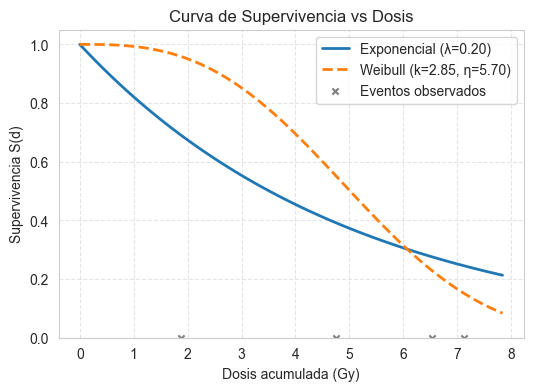

In [22]:


print(f"Distribución Exponencial:")
print(f"  λ̂ = {lambda_hat:.4f} evento/Gy")
print(f"  IC95% λ: [{lambda_ci_lower:.4f}, {lambda_ci_upper:.4f}]\n")

# Ajustar distribución Weibull
k_hat, loc_hat, eta_hat = st.weibull_min.fit(dose_to_failure, floc=0)
print(f"Distribución Weibull:")
print(f"  k̂ (shape) = {k_hat:.4f}")
print(f"  η̂ (scale) = {eta_hat:.4f} Gy")

# Bootstrap para IC95% (1000 remuestreos)
rng = np.random.default_rng(123)
n_boot = 1000
params = np.zeros((n_boot, 2))

for i in range(n_boot):
    sample = rng.choice(dose_to_failure, size=n, replace=True)
    kb, locb, etab = st.weibull_min.fit(sample, floc=0)
    params[i] = (kb, etab)

k_ci = np.percentile(params[:, 0], [2.5, 97.5])
eta_ci = np.percentile(params[:, 1], [2.5, 97.5])

print(f"  IC95% k: [{k_ci[0]:.4f}, {k_ci[1]:.4f}]")
print(f"  IC95% η: [{eta_ci[0]:.4f}, {eta_ci[1]:.4f}]\n")

# Preparar datos para la curva de supervivencia
d_max = dose_to_failure.max() * 1.1
d_vals = np.linspace(0, d_max, 100)

S_exp = np.exp(-lambda_hat * d_vals)
S_wb  = np.exp(-(d_vals / eta_hat)**k_hat)

# Graficar Curva de Supervivencia
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(d_vals, S_exp, label=f"Exponencial (λ={lambda_hat:.2f})", linewidth=2)
plt.plot(d_vals, S_wb, label=f"Weibull (k={k_hat:.2f}, η={eta_hat:.2f})", linestyle="--", linewidth=2)

# Mostrar eventos observados como cruces en y ≈ 0
plt.scatter(dose_to_failure, np.zeros_like(dose_to_failure),
            marker="x", color="black", s=20, alpha=0.5, label="Eventos observados")

# plt.yscale("log")
plt.ylim(0, 1.05)
plt.xlabel("Dosis acumulada (Gy)")
plt.ylabel("Supervivencia S(d)")
plt.title("Curva de Supervivencia vs Dosis")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.legend()
plt.show()


## Extracción del “tiempo entre fallos” (Time‐to‐Failure)

En lugar de dosis, podemos modelar la variable aleatoria  
$$
T = \text{“tiempo (segundos) entre un latch-up y el siguiente”}.
$$
Para ello:

1. Usamos `merged_latchups.index` (que son los timestamps de cada “Time_event”).
2. Calculamos las diferencias sucesivas en segundos:  
   $$
   \{\Delta t_i\} \;=\; \{\,t_{i} - t_{i-1}\}_{i=2\ldots N}.
   $$
3. Verificamos que todas las diferencias sean positivas (〈no hay eventos con fecha duplicada〉).
4. Ese vector `time_to_failure` en segundos se ajusta a una exponencial/Weibull análoga a la dosis.


----- Estadísticos descriptivos de Time‐to‐Failure -----
count        3.000000
mean     10782.967240
std       8839.152547
min       2935.398181
1%        3057.790103
5%        3547.357792
25%       5995.196234
50%       9054.994288
75%      14706.751770
95%      19228.157756
99%      20132.438953
max      20358.509252
Name: Time_to_Failure_s, dtype: float64


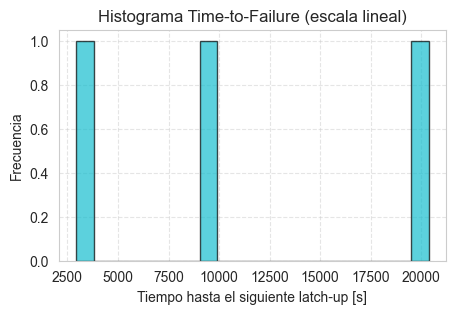

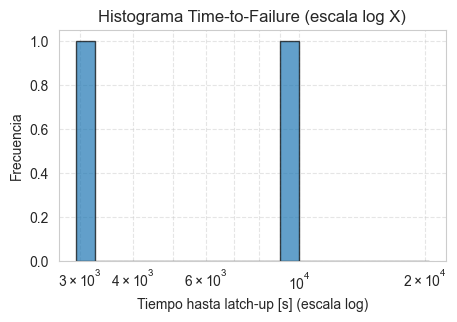

In [23]:
times_events = merged_latchups.index.sort_values()

# Calcular diferencias sucesivas en segundos
#    La primera fila no tiene “anterior”, así que descartamos el primer valor
delta = times_events.to_series().diff().dt.total_seconds().dropna().values

# Validaciones básicas
if np.any(delta <= 0):
    raise ValueError("Se detectaron diferencias no positivas entre eventos: revisar merged_latchups.")

time_to_failure = delta  # array de floats, segundos entre latch-ups

# Estadísticos descriptivos de TTF
ttf = pd.Series(time_to_failure, name="Time_to_Failure_s")
print("----- Estadísticos descriptivos de Time‐to‐Failure -----")
print(ttf.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))

# Histograma en escala lineal
plt.figure(figsize=(5, 3))
plt.hist(ttf, bins=20, color="tab:cyan", edgecolor="k", alpha=0.7)
plt.xlabel("Tiempo hasta el siguiente latch-up [s]")
plt.ylabel("Frecuencia")
plt.title("Histograma Time-to-Failure (escala lineal)")
plt.grid(True, ls="--", alpha=0.5)
plt.show()

# log
plt.figure(figsize=(5, 3))
bins_log = np.logspace(np.log10(ttf.min()), np.log10(ttf.max()), 20)
plt.hist(ttf, bins=bins_log, color="tab:blue", edgecolor="k", alpha=0.7)
plt.xscale("log")
plt.xlabel("Tiempo hasta latch-up [s] (escala log)")
plt.ylabel("Frecuencia")
plt.title("Histograma Time-to-Failure (escala log X)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

Para caracterizar la distribución del **tiempo hasta el siguiente latch-up** (TTF), suponemos que los intervalos $\{T_i\}$ entre eventos consecutivos siguen una distribución exponencial con parámetro $\lambda_{\rm time}$. Esto significa:

1. **Densidad de probabilidad**  
   $$
     f(t) \;=\; \lambda_{\rm time}\,\exp\bigl(-\lambda_{\rm time}\,t\bigr),
     \quad t \ge 0.
   $$

2. **Estimador de máxima verosimilitud (MLE)**  
   Dada una muestra de $n$ intervalos $\{T_1,\,T_2,\dots,T_n\}$, el MLE para $\lambda_{\rm time}$ es
   $$
     \hat\lambda_{\rm time} \;=\; \frac{1}{\overline{T}}
     = \frac{1}{\frac{1}{n}\sum_{i=1}^n T_i}.
   $$
   En código, esto se calcula como  
   ```python
   lambda_ttf = 1.0 / time_to_failure.mean()
   n_ttf = len(time_to_failure)
   sum_t  = time_to_failure.sum()

3. **Intervalo de confianza al 95 % para $\lambda_{\rm time}$**
   Sabemos que si $T_i \sim \mathrm{Exp}(\lambda)$, entonces

   $$
     S \;=\; \sum_{i=1}^n T_i \;\sim\; \mathrm{Gamma}\bigl(n,\tfrac{1}{\lambda}\bigr)
     \quad\Longrightarrow\quad
     2\,\lambda\,S \;\sim\; \chi^2_{2n}.
   $$

   Por lo tanto, un intervalo de confianza exacto al $1-\alpha$ para $\lambda$ viene dado por

   $$
     P\Bigl(\chi^2_{2n,\;\alpha/2} \le 2\,\lambda\,S \le \chi^2_{2n,\;1-\alpha/2}\Bigr) \;=\; 1-\alpha,
   $$

   lo que implica

   $$
     \lambda_{\rm time,\,lower} 
       = \frac{\chi^2_{2n,\;\alpha/2}}{2\,\sum_i T_i},
     \quad
     \lambda_{\rm time,\,upper} 
       = \frac{\chi^2_{2n,\;1-\alpha/2}}{2\,\sum_i T_i}.
   $$

   En Python usamos `scipy.stats.chi2.ppf` para los cuantiles de la $\chi^2$:

   ```python
   alpha  = 0.05
   chi2_l = st.chi2.ppf(alpha/2,    2 * n_ttf)
   chi2_u = st.chi2.ppf(1 - alpha/2, 2 * n_ttf)
   lambda_ttf_ci_lower = chi2_l / (2 * sum_t)
   lambda_ttf_ci_upper = chi2_u / (2 * sum_t)
   ```

   Finalmente, imprimimos $\hat\lambda_{\rm time}$ y su IC95 %.

  Con este procedimiento obtenemos la **tasa promedio de fallos por segundo** y un intervalo de confianza fiable para cuantificar la incertidumbre estadística en nuestro experimento.

  4. **Lidiar con el Sesgo**
  El estimador

  $$
  \hat\lambda_{\rm time} \;=\; \frac{1}{\overline{T}}
  \;=\; \frac{n}{\sum_{i=1}^n T_i}
  $$

  es en efecto el **MLE** (máxima verosimilitud) para $\lambda$ en una exponencial. Sin embargo, **no es insesgado**: su esperanza vale

  $$
  \mathbb{E}\bigl[\hat\lambda_{\rm time}\bigr] \;=\; \frac{n}{n-1}\,\lambda \quad(\text{para }n>1),
  $$

  de modo que sistemáticamente sobreestima a $\lambda$ en una proporción $\frac{n}{n-1}$.

  Para obtener un estimador **insesgado**, basta corregir ese factor:

  $$
  \tilde\lambda_{\rm time}
  \;=\; \frac{n-1}{\sum_{i=1}^n T_i}
  \quad\Longrightarrow\quad
  \mathbb{E}\bigl[\tilde\lambda_{\rm time}\bigr] \;=\; \lambda.
  $$

  En otras palabras:

  * **MLE (sesgado)**:

    ```python
    lambda_mle = 1.0 / time_to_failure.mean()   # = n / sum(time_to_failure)
    ```

    $\mathbb{E}[\lambda_{\rm mle}] = \frac{n}{n-1}\,\lambda$.

  * **Estimador insesgado**:

    ```python
    lambda_unbiased = (len(time_to_failure) - 1) / time_to_failure.sum()
    ```

    $\mathbb{E}[\lambda_{\rm unbiased}] = \lambda$.

  En la práctica, si $n$ es relativamente grande (por ejemplo, $n \gtrsim 30$), la corrección $\tfrac{n-1}{n}$ es pequeña y la diferencia entre ambos estimadores suele despreciarse. Pero conviene tenerlo en cuenta cuando $n$ es pequeño.




In [24]:
#  Ajuste de Exponencial para TTF
#lambda_ttf = 1.0 / time_to_failure.mean() # sesgado, aunque este sesgo disminuye con muchos datos
lambda_ttf = (len(time_to_failure) - 1) / time_to_failure.sum()

n_ttf = len(time_to_failure)
sum_t = time_to_failure.sum()
alpha = 0.05
chi2_l = st.chi2.ppf(alpha/2, 2*n_ttf)
chi2_u = st.chi2.ppf(1 - alpha/2, 2*n_ttf)
lambda_ttf_ci_lower = chi2_l / (2 * sum_t)
lambda_ttf_ci_upper = chi2_u / (2 * sum_t)

print("\nAjuste Exponencial (TTF):")
print(f"  lambda_time = {lambda_ttf:.6f} 1/s")
print(f"  IC95% lambda_time: [{lambda_ttf_ci_lower:.6f}, {lambda_ttf_ci_upper:.6f}]")


Ajuste Exponencial (TTF):
  lambda_time = 0.000062 1/s
  IC95% lambda_time: [0.000019, 0.000223]


In [25]:
# Calcular el tiempo medio hasta falla (sesgado corregido) en segundos
mean_ttf_sec = 1.0 / lambda_ttf
mean_ttf_hr = mean_ttf_sec / 3600.0

# Construir el intervalo de confianza para el tiempo medio:
#    Si lambda ∈ [lambda_lower, lambda_upper], entonces 
#    el tiempo medio ∈ [1/lambda_upper, 1/lambda_lower].
mean_ci_lower_sec = 1.0 / lambda_ttf_ci_upper
mean_ci_upper_sec = 1.0 / lambda_ttf_ci_lower

mean_ci_lower_hr = mean_ci_lower_sec / 3600.0
mean_ci_upper_hr = mean_ci_upper_sec / 3600.0

print("\nTiempo medio hasta latch-up (Exponencial) en horas:")
print(f"  Mean_TTF = {mean_ttf_hr:.2f} horas")
print(f"  IC95% Mean_TTF: [{mean_ci_lower_hr:.2f}, {mean_ci_upper_hr:.2f}] horas")


print("\n(Para referencia, en segundos:)")
print(f"  Mean_TTF = {mean_ttf_sec:.1f} s")
print(f"  IC95% Mean_TTF: [{mean_ci_lower_sec:.1f}, {mean_ci_upper_sec:.1f}] s")



Tiempo medio hasta latch-up (Exponencial) en horas:
  Mean_TTF = 4.49 horas
  IC95% Mean_TTF: [1.24, 14.52] horas

(Para referencia, en segundos:)
  Mean_TTF = 16174.5 s
  IC95% Mean_TTF: [4477.6, 52287.6] s


In [26]:
# === Ajuste de Weibull para TTF ===
k_ttf, loc_ttf, eta_ttf = st.weibull_min.fit(time_to_failure, floc=0)
print(f"\nAjuste Weibull (TTF): estimated k = {k_ttf:.4f}, estimated η̂= {eta_ttf:.1f} s")

# Bootstrap para IC95% (500 remuestreos por rapidez)
rng = np.random.default_rng(42)
n_boot = 500
params_ttf = np.zeros((n_boot, 2))
for i in range(n_boot):
    samp = rng.choice(time_to_failure, size=n_ttf, replace=True)
    kb, locb, etab = st.weibull_min.fit(samp, floc=0)
    params_ttf[i] = (kb, etab)

k_ttf_ci = np.percentile(params_ttf[:, 0], [2.5, 97.5])
eta_ttf_ci = np.percentile(params_ttf[:, 1], [2.5, 97.5])
print(f"  IC95% k_time: [{k_ttf_ci[0]:.4f}, {k_ttf_ci[1]:.4f}]")
print(f"  IC95% η_time: [{eta_ttf_ci[0]:.1f}, {eta_ttf_ci[1]:.1f}]")


Ajuste Weibull (TTF): estimated k = 1.5110, estimated η̂= 11987.3 s


c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\radiation\wenv\lib\site-packages\scipy\stats\_continuous_distns.py:2321: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  s = stats.skew(data)


  IC95% k_time: [1.0928, 171630492.3415]
  IC95% η_time: [2935.4, 20358.5]


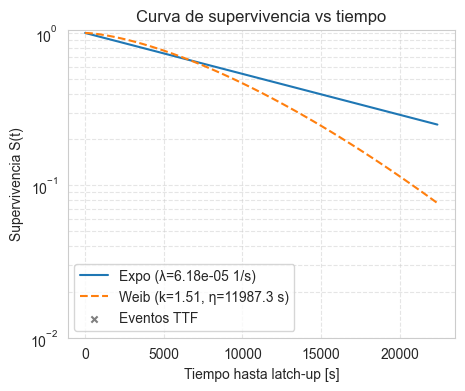

In [27]:
# Curva de supervivencia para tiempo (exponencial vs Weibull)
d_vals_t = np.linspace(0, time_to_failure.max() * 1.1, 100)
S_exp_t = np.exp(-lambda_ttf * d_vals_t)
S_wb_t  = np.exp(-(d_vals_t / eta_ttf)**k_ttf)

plt.figure(figsize=(5, 4))
plt.plot(d_vals_t, S_exp_t, label=f"Expo (λ={lambda_ttf:.2e} 1/s)")
plt.plot(d_vals_t, S_wb_t,  label=f"Weib (k={k_ttf:.2f}, η={eta_ttf:.1f} s)", linestyle="--")
plt.scatter(time_to_failure, np.zeros_like(time_to_failure), marker="x",
            color="black", s=20, alpha=0.5, label="Eventos TTF")
plt.yscale("log")
plt.ylim(1e-2, 1.05)
plt.xlabel("Tiempo hasta latch-up [s]")
plt.ylabel("Supervivencia S(t)")
plt.title("Curva de supervivencia vs tiempo")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()

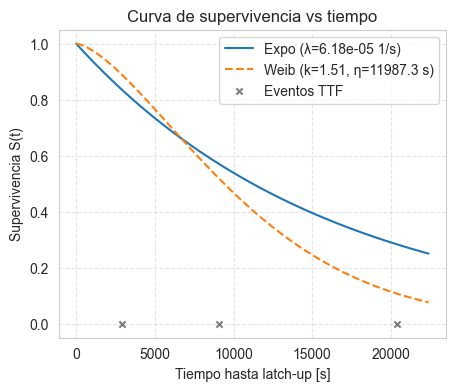

In [28]:
plt.figure(figsize=(5, 4))
plt.plot(d_vals_t, S_exp_t, label=f"Expo (λ={lambda_ttf:.2e} 1/s)")
plt.plot(d_vals_t, S_wb_t,  label=f"Weib (k={k_ttf:.2f}, η={eta_ttf:.1f} s)", linestyle="--")
plt.scatter(time_to_failure, np.zeros_like(time_to_failure), marker="x",
            color="black", s=20, alpha=0.5, label="Eventos TTF")
plt.xlabel("Tiempo hasta latch-up [s]")
plt.ylabel("Supervivencia S(t)")
plt.title("Curva de supervivencia vs tiempo")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()


## Relación con la función de riesgo (hazard)

- La **tasa instantánea de falla** o *hazard rate* $h(t)$ se define como
  $$
    h(t) \;=\; \lim_{\Delta t \to 0} \frac{P\bigl(t \le T < t + \Delta t \mid T \ge t\bigr)}{\Delta t}
    \;=\; -\frac{d}{dt}\bigl[\ln S(t)\bigr].
  $$
  Interpretación física: es la probabilidad instantánea, dado que aún no se ha fallado en $t$, de fallar justo después de $t$.  
- Relación clave:  
  $$
    S(t) \;=\; \exp\Bigl(-\!\int_{0}^{t} h(u)\,du\Bigr).
  $$

- Ejemplos de comportamiento de $h(t)$:  
  1. **Constante** ($h(t)=\lambda$) → modelo **exponencial** → curva $S(t) = e^{-\lambda t}$.  
  2. **Aumenta en el tiempo** (p. ej. $h(t)\propto t^{\,k-1},\,k>1$) → modelo **Weibull con $k>1$** (tasa de falla creciente, “envejecimiento”).  
  3. **Disminuye en el tiempo** (p. ej. $0<k<1$ en Weibull) → “fallos tempranos” que se concentran al principio y luego el sistema se estabiliza.  


# Post Reu 0606

Es necesario tener en cuenta
- verDAQ
- DMM

y cruzarlo con el Beam

Y alli entonces identificar lo que es un fallo.
Nota: Tener en cuenta que hay instantes con beam apagado


Ademas podemos tener $\delta t = 0.5 [ns]$